Source: https://qiskit.org/textbook/ch-algorithms/simon.html

In [1]:
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

In [2]:
b = '110'

n = len(b)

In [6]:
simon_circuit = QuantumCircuit(n*2,n)

#apply Hadamard gates before querying oracle
simon_circuit.h(range(n))
simon_circuit.barrier()

simon_circuit += simon_oracle(b)
simon_circuit.barrier()

simon_circuit.draw()

┌───┐ ░                           ░ 
q_0: ┤ H ├─░───■───────────────────────░─
     ├───┤ ░   │                       ░ 
q_1: ┤ H ├─░───┼────■─────────■────■───░─
     ├───┤ ░   │    │         │    │   ░ 
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ 
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░─
           ░           └───┘     └───┘ ░ 
c: 3/════════════════════════════════════

In [8]:
#apply Hadamard gates to the input registers and measure

simon_circuit.h(range(n))

simon_circuit.measure(range(n),range(n))

simon_circuit.draw()

┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

#### Experiment with Simulators

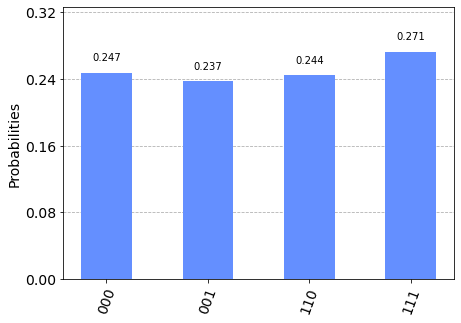

In [10]:
#local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024

qobj = assemble(simon_circuit, shots=shots)

results = aer_sim.run(qobj).result()
counts = results.get_counts()

plot_histogram(counts)

Now we verify that the results satisfy b * z = 0 (mod 2)

In [11]:
#calculate dot product of results
def bdotz(b,z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print(f"{b} * {z} = {bdotz(b,z)} (mod 2)")

110 * 001 = 0 (mod 2)
110 * 110 = 0 (mod 2)
110 * 000 = 0 (mod 2)
110 * 111 = 0 (mod 2)


#### Experiment with real devices

In [12]:
b = '11'
n = len(b)

In [13]:
simon_circuit_2 = QuantumCircuit(n*2, n)

#apply Hadamard gates, query the oracle, apply more Hadamard gates

simon_circuit_2.h(range(n))
simon_circuit_2 += simon_oracle(b)
simon_circuit_2.h(range(n))

#measure
simon_circuit_2.measure(range(n), range(n))

simon_circuit_2.draw()

┌───┐                         ┌───┐┌─┐
q_0: ┤ H ├──■─────────■─────────■──┤ H ├┤M├
     ├───┤  │         │  ┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├──┼────■────┼──┤ H ├──┼───┤M├──╫─
     └───┘┌─┴─┐  │  ┌─┴─┐└───┘  │   └╥┘  ║ 
q_2: ─────┤ X ├──┼──┤ X ├───────┼────╫───╫─
          └───┘┌─┴─┐└───┘     ┌─┴─┐  ║   ║ 
q_3: ──────────┤ X ├──────────┤ X ├──╫───╫─
               └───┘          └───┘  ║   ║ 
c: 2/════════════════════════════════╩═══╩═
                                     1   0

In [14]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(
            filters=lambda x: x.configuration().n_qubits >= n and 
            not x.configuration().simulator and x.status().operational==True))

print(f"Least busy backend: {backend}")

Least busy backend: ibmq_belem


In [16]:
from qiskit.tools.monitor import job_monitor

In [17]:
shots = 1024

transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level = 3)
qobj = assemble(transpiled_simon_circuit,shots=shots)

job = backend.run(qobj)
job_monitor(job,interval = 2)

<ipython-input-17-4f140503ed18>:6: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


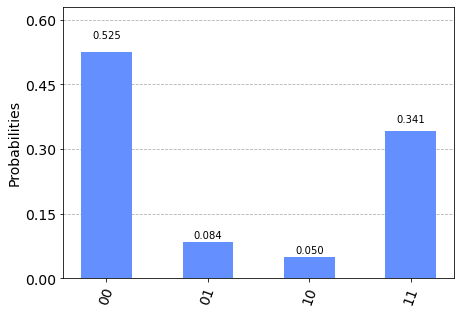

In [19]:
device_counts = job.result().get_counts()

plot_histogram(device_counts)

In [25]:
#calculate dot product of the results

def bdotz(b,z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return accum % 2

print(f"b = {b}")

for z in device_counts:
    print(f"{b} * {z} = {bdotz(b,z)} (mod 2) {round(device_counts[z]*100/shots,2)}%")

b = 11
11 * 00 = 0 (mod 2) 52.54%
11 * 01 = 1 (mod 2) 8.4%
11 * 10 = 1 (mod 2) 4.98%
11 * 11 = 0 (mod 2) 34.08%
